
# Finding The Ground State




## The Ansatz As A Solution


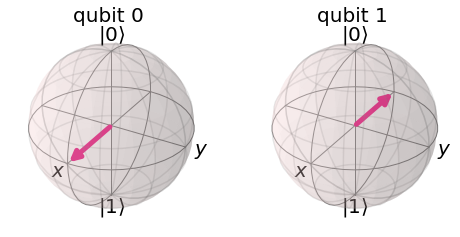

In [7]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_bloch_multivector

qc = QuantumCircuit(2) 
qc.h(0)
qc.h(1)
qc.z(1)

out = execute(qc,Aer.get_backend('statevector_simulator')).result().get_statevector()
plot_bloch_multivector(out)
#CAPTION Bloch Sphere representation of two spearate qubits

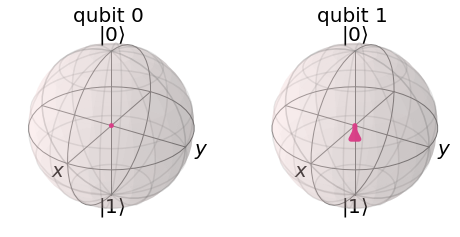

In [8]:
qc = QuantumCircuit(2) 

qc.h(0)
qc.cx(0,1)

out = execute(qc,Aer.get_backend('statevector_simulator')).result().get_statevector()
plot_bloch_multivector(out)
#CAPTION Bloch Sphere representation of an entangled state

In [9]:
import numpy as np
import qutip

def compute_meyer_wallach(ket, N):
    ket = qutip.Qobj(ket, dims=[[2]*(N), [1]*(N)]).unit()
    entanglement_sum = 0
    for k in range(N):
        rho_k_sq = ket.ptrace([k])**2
        entanglement_sum += rho_k_sq.tr()  
   
    Q = 2*(1 - (1/N)*entanglement_sum)
    return Q

In [11]:
n_qubits = 2
qc = QuantumCircuit(n_qubits) 
qc.h(0)
qc.h(1)
qc.z(1)

out = execute(qc,Aer.get_backend('statevector_simulator')).result().get_statevector().data
Q_value = compute_meyer_wallach(ket=out, N=n_qubits)
print('Q = {}\n'.format(round(Q_value, 2)))

Q = 0.0



We execute the circuit to obtain the resulting state vector as a list of the amplitudes. Then, we feed these amplitudes into the `compute_meyer_wallach` that returns `0.0`. This meets our expectations of an entirely unentangled states. Let's compare this to the second example that represents one of the Bell-states.

In [12]:
n_qubits = 2
qc = QuantumCircuit(n_qubits) 
qc.h(0)
qc.cx(0,1)

out = execute(qc,Aer.get_backend('statevector_simulator')).result().get_statevector().data
Q_value = compute_meyer_wallach(ket=out, N=n_qubits)
print('Q = {}\n'.format(round(Q_value, 2)))

Q = 1.0



In [13]:
from qiskit import Aer, QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from scipy.optimize import minimize_scalar, minimize
from numpy import pi


In [14]:
def ansatz(qc, qr, thetas, rounds=3):
    for r in range(rounds):
        for i in range(len(qr)):
            offset = r*len(qr)*2 +i*2
            
            qc.ry(thetas[offset], qr[i])
            qc.rz(thetas[offset+1], qr[i])
            
            if i > 0 and r < rounds - 1:
                qc.cx(qr[i-1], qr[i])
            
    return qc
#CAPTION Creating the ansatz

In [15]:
import random
random.seed()
qr = QuantumRegister(3, "qr")
cr = ClassicalRegister(1, "cr")
qc = QuantumCircuit(qr, cr)
rounds = 3
thetas =  list(map(lambda x: random.random(), [0] * ((1+rounds)*len(qr)*2)))
ansatz(qc, qr, thetas, rounds=rounds).draw()
#CAPTION Drawing the ansatz

┌─────────────┐┌─────────────┐     ┌─────────────┐┌──────────────┐»
qr_0: ┤ Ry(0.80647) ├┤ Rz(0.31902) ├──■──┤ Ry(0.22963) ├┤ Rz(0.053885) ├»
      ├─────────────┤├─────────────┤┌─┴─┐└─────────────┘├─────────────┬┘»
qr_1: ┤ Ry(0.56962) ├┤ Rz(0.52327) ├┤ X ├───────■───────┤ Ry(0.14481) ├─»
      ├─────────────┤├─────────────┤└───┘     ┌─┴─┐     └┬────────────┤ »
qr_2: ┤ Ry(0.94096) ├┤ Rz(0.57656) ├──────────┤ X ├──────┤ Ry(0.0261) ├─»
      └─────────────┘└─────────────┘          └───┘      └────────────┘ »
  cr: ══════════════════════════════════════════════════════════════════»
                                                                        »
«                          ┌──────────────┐┌─────────────┐                
«qr_0: ─────────────────■──┤ Ry(0.038259) ├┤ Rz(0.28491) ├────────────────
«      ┌─────────────┐┌─┴─┐└──────────────┘├─────────────┤ ┌─────────────┐
«qr_1: ┤ Rz(0.69768) ├┤ X ├───────■────────┤ Ry(0.20231) ├─┤ Rz(0.66519) ├
«      ├─────────────┤└───┘     ┌─┴─┐      ├─────────────┴┐├─────────────┤
«qr_2: ┤ Rz(0.36353) ├──────────┤ X ├──────┤ Ry(0.054825) ├┤ Rz(0.73287) ├
«      └─────────────┘          └───┘      └──────────────┘└─────────────┘
«  cr: ═══════════════════════════════════════════════════════════════════
«

In [16]:
out = execute(qc,Aer.get_backend('statevector_simulator')).result().get_statevector().data
Q_value = compute_meyer_wallach(ket=out, N=3)
print('Q = {}\n'.format(round(Q_value, 2)))
#CAPTION Calculating the degree of entanglement

Q = 0.35



In [17]:
from collections import defaultdict
from functools import reduce
from itertools import product
import numpy as np

PAULIS = {
    "I": np.eye(2, dtype=complex),
    "X": np.array([[0, 1], [1, 0]], dtype=complex),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),
    "Z": np.array([[1, 0], [0, -1]], dtype=complex),
}


def pauli_decomposition(H):
    n = int(np.log2(len(H)))
    dims = 2 ** n

    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")

    basis_key = ["".join(k) for k in product(PAULIS.keys(), repeat=n)]
    components = defaultdict(int)

    for i, val in enumerate(product(PAULIS.values(), repeat=n)):
        basis_mat = reduce(np.kron, val)
        coeff = H.reshape(-1).dot(basis_mat.reshape(-1)) / dims
        coeff = np.real_if_close(coeff).item()
        
        if not np.allclose(coeff, 0):
            components[basis_key[i]] = coeff

    return components


def matrix_decomposition_circuits(H,add_ansatz):
    n = int(np.log2(len(H)))
    dims = 2 ** n

    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")

    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        
        qr = QuantumRegister(n, "qr")
        cr = ClassicalRegister(1, "cr")
        qc = QuantumCircuit(qr, cr)
        
        add_ansatz(qc, qr)

        # don't do anything if all Paulis are I
        if all(x[1] == "I" for x in paulis):
            # we use this empty circuit that we will measure as "0" (eigenvalue 1) in all cases
            circuits[paulistring] = (qc, weight)
            continue
        
        # do the single qubit transformations
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
                
        # add the inter-qubit gates
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.cx(first[0], second[0])
            
        # measure the highest qubit
        qc.measure(qr[-1], cr[0])
        circuits[paulistring] = (qc, weight)
        
    return circuits

In [18]:
rounds = 3
circuits = matrix_decomposition_circuits(
    np.array(
        [[1, 3, 1, 3], [3, 0,0,0], [1,0,1,3], [3,0,3,0]],
        dtype=complex
    ),
    lambda qc, qr: ansatz(qc, qr, list(map(
        lambda x: random.random(),
        [0] * ((1+rounds)*len(qr)*2)
    )), rounds=3)
)

circuits["XZ"][0].draw()
#CAPTION Decomposition of a 4x4 matrix with an ansatz

┌─────────────┐ ┌─────────────┐      ┌─────────────┐┌─────────────┐     »
qr_0: ┤ Ry(0.64907) ├─┤ Rz(0.20776) ├───■──┤ Ry(0.51889) ├┤ Rz(0.54758) ├──■──»
      ├─────────────┤┌┴─────────────┴┐┌─┴─┐├─────────────┤├─────────────┤┌─┴─┐»
qr_1: ┤ Ry(0.11307) ├┤ Rz(0.0064693) ├┤ X ├┤ Ry(0.59387) ├┤ Rz(0.38212) ├┤ X ├»
      └─────────────┘└───────────────┘└───┘└─────────────┘└─────────────┘└───┘»
  cr: ════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ┌─────────────┐┌─────────────┐              
«qr_0: ┤ Ry(0.64606) ├┤ Rz(0.74086) ├────────■─────
«      ├─────────────┤├─────────────┴┐┌───┐┌─┴─┐┌─┐
«qr_1: ┤ Ry(0.92418) ├┤ Rz(0.061296) ├┤ H ├┤ X ├┤M├
«      └─────────────┘└──────────────┘└───┘└───┘└╥┘
«  cr: ══════════════════════════════════════════╩═
«

In [19]:
def expectation(H, rounds, thetas):
    backend = Aer.get_backend('qasm_simulator')
    circuits = matrix_decomposition_circuits(
        H,
        lambda qc, qr: ansatz(qc, qr, thetas, rounds)
    )
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend)*circuits[key][1], circuits.keys()))

<!--
**References**

https://born-2learn.github.io/posts/2021/01/effect-of-entanglement-on-model-training/
https://github.com/born-2learn/Entanglement_in_QML/blob/main/libraries/meyer_wallach_measure.py

https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb

1. Sim, Sukin, Peter D. Johnson, and Alán Aspuru‐Guzik. 2019. “Expressibility and Entangling Capability of Parameterized Quantum Circuits for Hybrid Quantum‐Classical Algorithms.” *Advanced Quantum Technologies*, October, 1900070. [https://doi.org/10.1002/qute.201900070.](https://doi.org/10.1002/qute.201900070.)
2. Meyer, David A., and Nolan R. Wallach. 2002. “Global Entanglement in Multiparticle Systems.” *Journal of Mathematical Physics* 43 (9): 4273–78. [https://doi.org/10.1063/1.1497700.](https://doi.org/10.1063/1.1497700.)
3. Kyaw, Thi Ha, Tim Menke, Sukin Sim, Nicolas P. D. Sawaya, William D. Oliver, Gian Giacomo Guerreschi, and Alán Aspuru-Guzik. 2020. “Quantum Computer-Aided Design: Digital Quantum Simulation of Quantum Processors,” June. [http://arxiv.org/abs/2006.03070.](http://arxiv.org/abs/2006.03070.)
4. Nakaji, Kouhei, and Naoki Yamamoto. 2020. “Expressibility of the Alternating Layered Ansatz for Quantum Computation.” [http://arxiv.org/abs/2005.12537.](http://arxiv.org/abs/2005.12537.)
5. Hubregtsen, Thomas, Josef Pichlmeier, and Koen Bertels. 2020. “Evaluation of Parameterized Quantum Circuits: On the Design, and the Relation between Classification Accuracy, Expressibility and Entangling Capability.” [http://arxiv.org/abs/2003.09887.](http://arxiv.org/abs/2003.09887.) -->